# Part 3: Neural Networks for Neural Data of a single Participant

First we load the necessary libraries

In [1]:
! pip install mne
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_recall_fscore_support

In [2]:
import requests
def download_file(url, outfile=None):
    if not outfile:
        outfile = url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(outfile, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)


"\nimport requests\ndef download_file(url, outfile=None):\n    if not outfile:\n        outfile = url.split('/')[-1]\n    with requests.get(url, stream=True) as r:\n        r.raise_for_status()\n        with open(outfile, 'wb') as f:\n            for chunk in r.iter_content(chunk_size=8192): \n                f.write(chunk)\n"

In [3]:
download_file('https://github.com/fma0/AMLD/blob/main/902-P.fif?raw=true', outfile='902-P.fif')

## Data loading and preparing

### Exercise 1: 
Training the first neural network on patient 902

1. Load the .fif file that we used before. 
2. Extract the data and labels
3. As descibed in the lecture we need to normalize the data (**Tip**: Each trial seperately, and with the function normalize, given bellow)
4. We should use one-hot encoded labels, we can use the function '[to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)' from tensorflow.keras.utils

In [4]:
def normalize(volume):
    # input a single trial, of the shape (Channels) x (Time)
    stdev = np.std(volume, dtype=np.float64)
    mean = np.mean(volume, dtype=np.float64)
    return (volume - np.float32(mean)) / np.float32(stdev)

In [5]:
# solution
data_file = '902-P'
epochs = mne.read_epochs(data_file + '.fif', verbose='error')

data = epochs.get_data()
labels = np.where(epochs.events[:,-1] == 201, 0, 1)
labels = to_categorical(labels)
for i, sample in enumerate(data):
    data[i] = normalize(sample)

Convolutional neural networks have been traditionally used on images, with 3 dimensions: (X-axis) x (Y-axis) x (color channels). There we don't have multiple channels, which means we just expand the data in the last dimension such that the data shape then is (Channels) x (Time) x (1):

In [6]:
data = np.expand_dims(data, axis=-1)
print(data.shape)

(154, 60, 301, 1)


### Exercise 2:
Create the train and test data sets with the train_test_split as in 'Part 2: Machine Learning'

In [7]:
# solution
train_data, test_data, labels_train, labels_test = train_test_split(data, labels, 
                                                                    test_size=0.2, 
                                                                    random_state=42)


## Defining the model

Now let's define the model, it takes as input : the number of classes, the number of recorded EEG channels and the number of time points per trial.

**Disclaimer:** We are using EEGNet, which was developped by [Lawhern et. al. (2017)](https://github.com/vlawhern/arl-eegmodels). This network and the below imported code was writen by Lawhern. 

In [8]:
download_file("https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py")
from EEGModels import EEGNet

In [9]:
tf.random.set_seed(42)

### Exercise 3:
Define these three variables:

In [10]:
# solution
n_classes = 2
n_channels = data.shape[1]
n_timepoints = data.shape[2]

In [11]:
model = EEGNet(n_classes, n_channels, n_timepoints)

2022-03-26 00:50:34.722774: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 00:50:34.723068: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Before training we need to compile the network, there we specify the loss, optimizer, learning rate and any other metric that we would like to keep track of. 
We currently keep track of the accuracy and the AUC score, you are free to add anything else you find meaningfull. Check out https://www.tensorflow.org/api_docs/python/tf/keras/metrics for a list of possibilities. 

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', lr=0.1, 
              metrics=['accuracy', 'AUC'])

## Training the model

Then we train the model for 50 epochs. We set the percentage of trials for the validation set with the variable validation_split (here 20%). 

In [13]:
history = model.fit(train_data, labels_train, validation_split=0.2, epochs=50)

Train on 98 samples, validate on 25 samples
Epoch 1/50
98/98 [==============================] - 4s 41ms/sample - loss: 0.8565 - accuracy: 0.4388 - AUC: 0.3831 - val_loss: 0.6889 - val_accuracy: 0.7200 - val_AUC: 0.7376
Epoch 2/50
98/98 [==============================] - 1s 12ms/sample - loss: 0.6521 - accuracy: 0.7449 - AUC: 0.7297 - val_loss: 0.6844 - val_accuracy: 0.8000 - val_AUC: 0.7488
Epoch 3/50
98/98 [==============================] - 1s 10ms/sample - loss: 0.6187 - accuracy: 0.7857 - AUC: 0.8199 - val_loss: 0.6800 - val_accuracy: 0.8000 - val_AUC: 0.7840
Epoch 4/50
98/98 [==============================] - 1s 12ms/sample - loss: 0.5959 - accuracy: 0.8163 - AUC: 0.8501 - val_loss: 0.6756 - val_accuracy: 0.8000 - val_AUC: 0.7840
Epoch 5/50
98/98 [==============================] - 1s 13ms/sample - loss: 0.5651 - accuracy: 0.8265 - AUC: 0.8532 - val_loss: 0.6712 - val_accuracy: 0.8000 - val_AUC: 0.8080
Epoch 6/50
98/98 [==============================] - 1s 11ms/sample - loss: 0.5582

98/98 [==============================] - 1s 10ms/sample - loss: 0.3059 - accuracy: 0.9082 - AUC: 0.9631 - val_loss: 0.5229 - val_accuracy: 0.8000 - val_AUC: 0.8352
Epoch 48/50
98/98 [==============================] - 1s 11ms/sample - loss: 0.3303 - accuracy: 0.8571 - AUC: 0.9593 - val_loss: 0.5297 - val_accuracy: 0.8000 - val_AUC: 0.8320
Epoch 49/50
98/98 [==============================] - 1s 10ms/sample - loss: 0.2978 - accuracy: 0.8980 - AUC: 0.9780 - val_loss: 0.5229 - val_accuracy: 0.8000 - val_AUC: 0.8336
Epoch 50/50
98/98 [==============================] - 1s 11ms/sample - loss: 0.2954 - accuracy: 0.9184 - AUC: 0.9721 - val_loss: 0.5054 - val_accuracy: 0.8000 - val_AUC: 0.8576


## Model evaluation

Let's evaluate how the learning of the model progressed during the training. The history variable contains the progresssion of the models evaluated on the metrics, that we gave to the model before as well as the loss. The history contains the vlues for the train and validation (called with a prefix of 'val_') metrics. We can see all that it keeps track of with:

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])

In [15]:
def plot_history(history, key):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_xlabel('Epochs')
    ax.set_ylabel(key.capitalize())

    plt.plot(history.history[key], color='C0', label = 'Train', linewidth=2)
    plt.plot(history.history['val_'+key], color='C3', label='Validation', linewidth=2)

    legend = ax.legend(fontsize='medium')
    ax.set_title('Model ' + key.capitalize())
    plt.show()

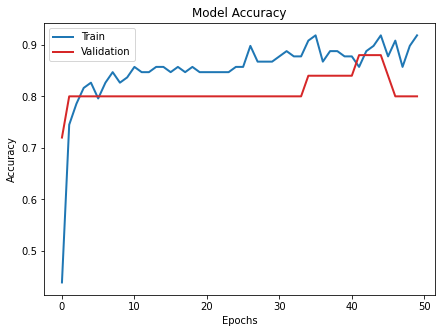

In [16]:
plot_history(history, 'accuracy')

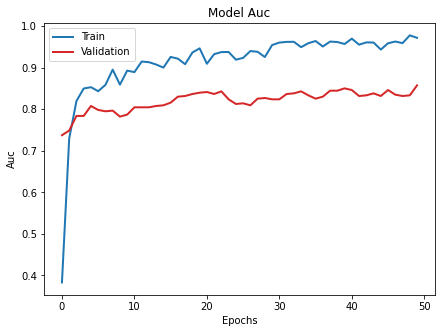

In [17]:
plot_history(history, 'AUC')

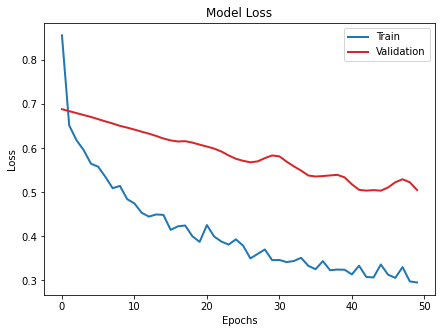

In [18]:
plot_history(history, 'loss')

### Exercise 4:
Now we avaluate the performance:
1. We will need the predictions and true labels to only have a single dimensional for the f1-score function. Which are both given bellow as predictions and true labels for the train set. Also calculate them for the test set. 
2. Then evaluate the f-score for the train set and the test set.

Is the performance increased?

In [19]:
predictions_train = np.argmax(model.predict(train_data), axis=1)
true_labels_train = np.argmax(labels_train, axis=1)

# solution
predictions_test = np.argmax(model.predict(test_data), axis=1)
true_labels_test = np.argmax(labels_test, axis=1)

print(f'The F1-score for the train set is {f1_score(true_labels_train, predictions_train) : .2f}')
print(f'The F1-score for the test set is {f1_score(true_labels_test, predictions_test) : .2f}')

The F1-score for the train set is  0.61
The F1-score for the test set is  0.60


## Saliency maps

We already precomputed the Saliency maps, they are saved in the file '902-P-Saliency.fif'

In [20]:
download_file('https://github.com/fma0/AMLD/blob/main/902-P-Saliency.fif?raw=true', 
              outfile='902-P-Saliency.fif')
data_file_s = '902-P-Saliency'
epochs_s = mne.read_epochs(data_file_s + '.fif', verbose='error')

### Exercise 5:
Plot the topographic map representation of the Saliency maps for both classes and for the following timepoints:

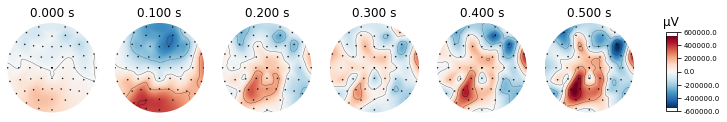

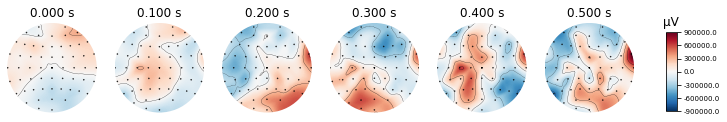

In [21]:
timepoints = np.arange(0, 0.51, 0.1)

# solution
epochs['Standard'].average().plot_topomap(timepoints, ch_type='eeg');
epochs['Novel'].average().plot_topomap(timepoints, ch_type='eeg');